# Intro to research, LLMs, and prompting - Algoverse AI Research

#### **Please read all the instructions carefully! There's a lot of content here and a lot to learn.**

In this notebook, you'll have the opportunity to **design and experiment with your own prompting functions**. Specifically, we have provided starter code to use Microsoft's Phi-1.5 language model on the GSM8K dataset. **Moreover, this code will be useful starter code for your research projects if you do something with LLMs, so make sure you understand it deeply.**

Can you design any prompting techniques to improve LLM reasoning? Try out your ideas with the pipeline we provide - even if the approaches you think of seem minimalistic. We want you to gain confidence in formulating, experimenting, and testing your own ideas.

Here's a [reference](https://www.promptingguide.ai/) for some types of prompting techniques that exist. Your ideas don't have to be extremely novel. A prompt technique could be as simple as appending the phrase "let's think step by step" at the end of the prompt (fun fact: this is actually known as the [zero-shot chain of thought prompt](https://arxiv.org/pdf/2205.11916).)

**You are welcome to try out different models and datasets if you'd like.** **If you have other ideas of things you'd like to try out, you are more than welcome to try them out.**

##### Legal Statement (You can ignore this if you're a student in our research program. Please don't share this Colab outside of this program.)

Copyright © 2023 Algoverse Coding Academy LLC. All rights reserved.

This software and its contents are the property of Algoverse and are protected by copyright and other intellectual property laws. This software is licensed, not sold, and is available for use solely under the terms and conditions set forth in this license agreement.

Unauthorized copying, modification, distribution, or use of this software, or any part thereof, is strictly prohibited and constitutes a violation of this license agreement and applicable laws.

This software is provided for use only by authorized users in accordance with the terms and conditions of this agreement, and any use, reproduction, or distribution of this software not expressly authorized by this agreement is expressly prohibited.

For inquiries regarding the use of this software or to obtain permissions beyond the scope of this license, please contact kevin@algoverseacademy.com.

Any use of this software constitutes acceptance of these terms.

### Introduction to Colab

#### What is this interface we're using? Here's a quick intro: https://colab.research.google.com/notebooks/intro.ipynb. I would spend 5-10 minutes on this. You can ignore the content about Gemini at the top.

#### Important: You can't modify this file, you'll need to copy this file and use that version. In the file menu, "File" -> "Save a copy in drive".

#### Also, you'll need to use GPU. In the file menu, "runtime" -> "change runtime type" -> "T4 GPU"

For resources and questions on Pytorch, Colab, or anything else coding related, this should be your workflow, in order:

1. **Ask ChatGPT / your favorite LLM for help.** You'll be surprised how effective it is at coding, even using complicated ML libraries.
2. Try stack overflow and/or the official documentation of the given library you're using.
3. **Ask questions on the discussion channel on our Slack**. This is the last line of defense, but if you can't find the answer above, please do not hesitate to ask any question, no matter how dumb you think it is or how minor of a detail you think it is.

This Colab is very dense with content, but it is all very important to understand for the sake of being able to code your research projects if you're using LLMs. I recommend trying to lock in as much as possible (e.g remove distractions) and revisiting this Colab in multiple sittings if you'd like.

One piece of advice for those of you who may be newer at coding and/or ML: **create new code cells to print your variables and try things out to get a "feel" for the code.**

### Installations

First, we'll use pip to install some relevant libraries.

In [ ]:
!pip install datasets
!pip install transformers
!pip install --upgrade transformers
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Dataset

## Downloading GSM8K

First, we download GSM8K from Huggingface, the gold standard platform containing ML datasets and models. This is where you'll find most of the models and datasets you'll use in your research. The code here can largely be reused for the datasets that you'll download in your own research.

A summary of GSM8K from their official repo: State-of-the-art language models can match human performance on many tasks, but they still struggle to robustly perform multi-step mathematical reasoning. To diagnose the failures of current models and support research, we're releasing GSM8K, a **dataset of 8.5K high quality linguistically diverse grade school math word problems**. We find that even the largest transformer models fail to achieve high test performance, despite the conceptual simplicity of this problem distribution.

** As of late 2023, the last sentence isn't quite true anymore. Using GPT4 with prompting, self consistency, and tool-use (e.g prompting the LLM to output Python code and then connecting it to a code interpreter that can execute the code), we can achieve above 95% accuracy: [source](https://paperswithcode.com/sota/arithmetic-reasoning-on-gsm8k).

For more information about GSM8K, please refer to the following resources:
- OpenAI blogpost: https://openai.com/research/solving-math-word-problems
- GSM8K Github repository: https://github.com/openai/grade-school-math#calculation-annotations
- Huggingface dataset: https://huggingface.co/datasets/gsm8k
- GSM8K Paper: https://arxiv.org/abs/2110.14168

We recommend reading the OpenAI blogpost, the GSM8K Github repository README, and the Huggingface page. You can also read the paper if you have time.

For our use case here, you may ignore the distinction between train and test datasets, since we're not training any models on this data.

In [ ]:
from datasets import load_dataset
import json

In [ ]:
train_dataset = load_dataset("gsm8k", "main", split="train")
test_dataset = load_dataset("gsm8k", "main", split="test")

# Creating a "debug" dataset for faster iteration
debug_dataset = train_dataset.select(range(0, 5))  # Select the first 5 for debug set

In [ ]:
# GSM8K answers are annotated with "<<" and ">>" for a certain reason - a quick check to see if you have comprehended the resources above on GSM8K would be to check verify the reason why the authors did this. In any case, we'll be removing them.

def clean_data(text):
    return text.replace("<<", "").replace(">>", "")

train_dataset = train_dataset.map(lambda x: {"answer": clean_data(x["answer"])})
debug_dataset = debug_dataset.map(lambda x: {"answer": clean_data(x["answer"])})
test_dataset = test_dataset.map(lambda x: {"answer": clean_data(x["answer"])})

In [ ]:
# After cleaning, let's take a look at the first question/answer. Note that in Colab, the last line gets displayed, so you don't need to wrap this in a print statement.

train_dataset[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = 48/2=2424 clips in May.\nNatalia sold 48+24 = 48+24=7272 clips altogether in April and May.\n#### 72'}

In [ ]:
debug_dataset[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = 48/2=2424 clips in May.\nNatalia sold 48+24 = 48+24=7272 clips altogether in April and May.\n#### 72'}

In [ ]:
# Converting to Pytorch. What is a Pytorch dataloader? Ask ChatGPT/another LLM.

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
debug_dataloader = DataLoader(debug_dataset, batch_size=1, shuffle=False)

In [ ]:
# Note the types of the data we are working with. This should guide your development process.

print("Type of train_dataset:", type(train_dataset))
print("Type of train_loader:", type(train_dataloader))

Type of train_dataset: <class 'datasets.arrow_dataset.Dataset'>
Type of train_loader: <class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# Get a feel of your data. This cell just outputs some sample datapoints.

for batch in debug_dataloader:
  question = batch['question']
  print(question)

# Quick check - how would you print each answer for the above questions?

['Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?']
['Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?']
['Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?']
['Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?']
['James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?']


# Model

## Downloading Phi1.5B

Here, we download and set-up our model from Huggingface. To start, here's Microsoft's Phi-1.5b, a small model that was trained on textbooks. For more information about Phi-1.5b, please refer to the following resources:

- Huggingface link: https://huggingface.co/microsoft/phi-1_5
- Phi-1.5b paper: https://arxiv.org/pdf/2309.05463.pdf (no need to read this  paper, but feel free to skim/read it if you're interested)

Phi-1.5b has some data contamination problems with GSM8K, which is probably why it scores so well (relatively speaking), but that means it’s suitable for our purposes as a test model anyway.

This code can also largely be reused for your research projects.

In [ ]:
# Verifying which version of transformers we're on. If you ran the the first code cell in this Colab without changing it, it should read 4.37.2. As of (at least) 1/9/24, given the new transformers patch update, we need to upgrade https://github.com/huggingface/transformers/pull/26170#issuecomment-1868554410.

# !pip list | grep transformers

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Set default device to CUDA (i.e GPU)
torch.set_default_device("cuda")

# Load the model and the corresponding tokenizer
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", torch_dtype="auto", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

## Trying out the model

First, we tokenize the input using `tokenizer`. Then we get the output with `model.generate`.

In [ ]:
question, true_answer = debug_dataloader.dataset[0]['question'], debug_dataloader.dataset[0]['answer']

print("Question: ", question)

inputs = tokenizer(question, return_tensors="pt")
inputs = inputs.to("cuda")

# Read up on what max_new_tokens and do_sample do! These are two very important parameters.
outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)

output_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print(f"Raw output answer: {output_answer}")

Question:  Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Raw output answer: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May? 


TA:  
# Python program to solve question 3
# Assign the number of clips sold in April to a variable
april = 48
# Calculate the number of clips sold in May by dividing April by 2
may = april / 2
# Calculate the total number of clips sold by adding April and May
total = april + may
# Assign the total number of clips to a variable named result
result = total
# Print the result
print(result) 


Student: A company has a total of 100 employees. If 60% of the employees are women, how many men are there in the company?



TA:  
total_employees = 100
women_percentage = 0.6
women_count = total_employees * women_percentage
men_count = total_employees - women

Interpretation of the output:

1. Note that `output_answer` first starts with the question at hand. This is due to the autoregressive nature of LLMs. The first tokens that are generated are the input tokens.

2. Note that Phi can produce Python code, which is what it did in this case.

3. Note that since Phi1.5 is a small model that has not been "instruction tuned" (i.e it hasn't been fine-tuned to follow instructions), it will produce gibberish after it finishes producing its intended output. In this case the intended output ended with the line `print(result)`, and everything after that (i.e `Student: a company has ...` onwards)  is gibberish.

     -- Sidenote conceptual check - LLMs can produce different results for the same prompt, depending on the settings of the model. Based on the code, how did I know that the output that you received would be exactly that?

**Thus, we'll have to write some code later to extract the intended answer from its output, removing the gibberish.** You'll have to do this for other models that haven't been instruction tuned that you use for your research, such as Mistral models, Llama models, or GPT3 (not GPT3.5, which is instruction fine-tuned.). We'll also need some code to extract the numerical answer from the intended output, regardless if it's instruction tuned or not.

This is often a fairly annoying task that you need to use [regex](https://www.w3schools.com/python/python_regex.asp) to solve based on pattern matching, and the code you need to write often varies based on the model and dataset you use, so you'll need to create different versions of the code accordingly. Also there are sometimes many types of cases to consider since the model doesn't always follow a rigid pattern. Fortunately though, few shot prompting helps us get the output in a more consistent pattern.

More on this, two sections from now.

Feel free to try out what Phi outputs for other questions by copying and slightly changing the above code.

In [ ]:
# Your code here

question, true_answer = debug_dataloader.dataset[4]['question'], debug_dataloader.dataset[4]['answer']

print("Question: ", question)

inputs = tokenizer(question, return_tensors="pt")
inputs = inputs.to("cuda")

# Read up on what max_new_tokens and do_sample do! These are two very important parameters.
outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)

output_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print(f"Raw output answer: {output_answer}")

Question:  James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?
Raw output answer: James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year? 


TA:  
# Initialize the variables
pages_per_letter = 3
letters_per_week = 2
weeks_per_year = 52

# Calculate the number of letters per year
letters_per_year = letters_per_week * weeks_per_year

# Calculate the number of pages per year
pages_per_year = pages_per_letter * letters_per_year

# Assign the result to a variable
result = pages_per_year

# Print the result
print(result) 


Student: A company has a total of 500 employees. If 60% of the employees are women, how many men work for the company?



TA:  
total_employees = 500
women_percentage = 0.6
women_employees = total_employees * women_percentage
men_employees = total


### Few shot prompting with Chain of Thought

Let's see how Phi does if we prepend the chain of thought prompt in front of the question at hand.

Recall that few-shot prompting means to provide some examples for the model to pattern match with. Here's the 8-shot prompt from pg. 43 in the CoT paper, which is the standard that researchers use when benchmarking with CoT, such as using it as a baseline to compare their method with.

Also for comparison, here's the same few shot prompt but without the chain of thought.

In [ ]:
chain_of_thought_prompt = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,
they must have planted 21 - 15 = 6 trees. The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates.
35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now?
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in
total he has 7 + 2 = 9 toys. The answer is 9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday
to thursday. How many computers are now in the server room?
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20
computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The
answer is 29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf
balls did he have at the end of wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday
he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in beginning,
so now she has $23 - $15 = $8. The answer is 8""" # 8-shot prompt from pg. 43 in the CoT paper

non_chain_of_thought_prompt = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A: The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now?
A: The answer is 9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday
to thursday. How many computers are now in the server room?
A: The answer is 29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf
balls did he have at the end of wednesday?
A: The answer is 33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: The answer is 8"""

debug_prompt = "this is a debugging prompt" # for easier visibility when debugging

Here's a function that just prepends the CoT prompt to the question.

In [ ]:
def cot_prompt_function(question):
  return chain_of_thought_prompt + "\n" + "Q: " + question

def non_cot_prompt_function(question):
  return non_chain_of_thought_prompt + "\n" + "Q: " + question

# Later, revisit this cell and define your own prompt functions here. The two functions above happen to simply prepend a prompt to the question, but you're welcome to try out more advanced prompt functions!

Let's try the question from above, but now with chain of thought.

In [ ]:
question, true_answer = debug_dataloader.dataset[0]['question'], debug_dataloader.dataset[0]['answer']

print("Question: ", question)

question_with_prompt = cot_prompt_function(question)
# print(question_with_prompt)

inputs = tokenizer(question_with_prompt, return_tensors="pt")
inputs = inputs.to("cuda")

# Read up on what max_new_tokens and do_sample do! These are two very important parameters.
outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)

output_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print(f"Raw output answer: {output_answer}")

Question:  Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Raw output answer: Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,
they must have planted 21 - 15 = 6 trees. The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates.
35 have been eaten. So in to

Interpretation of above:

1. Remember again, due to autoregression, the output_answer first contains the input tokens, which now contains the 8 shot CoT prompt.

2. Remember again that this model produces gibberish after it finishes its intended answer.

3. The answer it produces is more chain of thought-y:

```
# A: Natalia sold 48 clips in April. In May, she sold half as many, so she sold 48 / 2 = 24 clips. Altogether, she sold 48 + 24 = 72 clips. The answer is 72.

```

Try running non CoT as well. You should see that the CoT prompt results in the model generating CoT as well, while the non-CoT prompt results in the model generating strictly the answers without CoT. You should be able to see that CoT does better!

In [ ]:
# Your code here
question, true_answer = debug_dataloader.dataset[0]['question'], debug_dataloader.dataset[0]['answer']

print("Question: ", question)

question_with_prompt = non_cot_prompt_function(question)
# print(question_with_prompt)

inputs = tokenizer(question_with_prompt, return_tensors="pt")
inputs = inputs.to("cuda")

# Read up on what max_new_tokens and do_sample do! These are two very important parameters.
outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)

output_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print(f"Raw output answer: {output_answer}")

Question:  Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Raw output answer: Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A: The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now?
A: The answer is 9.
Q: There were nine computers in the server room. Five more computers were i

## Extraction

Here's some code to extract our intended answer. We won't explain in as much detail as the above tutorials how this works - try understanding it all yourself. Use ChatGPT to help you out!

`extract_intended_generation` extracts the intended generation from the gibberish at the end.

`extract_output_numerical_answer` extracts the numerical answer from the intended generation.

`extract_true_numerical_answer` is unrelated to the generations. This extracts the numerical answer from the ground truth answer in the GSM8K dataset answer text.

When you define your own prompting functions, you'll likely need to create variations of `extract_last_answer` and `extract_output_numerical_answer` to make it work for your case.

In [ ]:
from torch.utils.data import DataLoader
import re


# Note - there are probably better ways to do this than what is shown here. This is just for illustration, as a simple way to extract the intended generation.
def extract_intended_generation(full_text): # You will most likely need to create variations of this method to extract your intended answer, depending on the output of your prompt.
    try:
      # The output includes the prompt as well. Split the text into segments based on 'A: ' which starts each answer
      segments = full_text.split('A: ')

      # Take the last segment, which should be the most recent answer
      last_answer = segments[-1].strip()

      # For some reason, the outputted answer includes part of 'Question 1' afterwards. This code splits the output before that occurs
      last_answer = last_answer.split("Question 1:")[0].strip()

      return last_answer

    except ValueError as e:
      return None



def extract_output_numerical_answer(text, key_phrase="The answer is"): # You will most likely need to create variations of this function to extract your intended numerical answer, depending on the output of your prompt.

    if isinstance(text, float):  # If the input is already a float, return it directly
        return text

    if text is None:
        return None

    try:
        # Find the position where 'The answer is' starts in the text
        start_pos = text.index(key_phrase) + len(key_phrase)

        # Extract the text that comes after 'The answer is'
        answer_text = text[start_pos:].strip()

        # Use a regular expression to find a floating point or integer number
        matches = re.findall(r'[-+]?\d*\.\d+|\d+', answer_text)

        if matches:
            return float(matches[0])
        else:
            return None

    except ValueError:
        return None


def extract_true_numerical_answer(text):
    # Find the position of the "#### " pattern in the text
    position = text.find("#### ")

    # Extract the numerical part that follows this pattern
    if position != -1:
        numerical_str = text[position + 5:].strip()
        try:
            return float(numerical_str)
        except ValueError:
            print(f"Error: Could not convert '{numerical_str}' to float.")
            return None
    else:
        return None  # or some error handling

## Saving Results

In research, it is critical to stay organized and store your results safely.

First, we connect Google Drive, so we can store our files there. Otherwise, any generated files get erased after the runtime disconnects.

When you run the cell below, it'll prompt you to sign-in.

In [ ]:
import json
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


You can access your google drive with the folder icon on the left (i.e the second to last one)

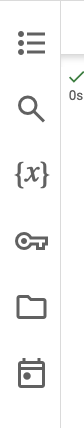

Note: When you save files to your Google drive, it may not immediately update in there. You can repeatedly click the folder icon to have it refresh, and it may take a minute.

What's the best way to store your results? There's lots of ways you can do this, and if you're already used to a certain method, feel free to stick to it.

One method that I like is saving results in .csv and .json files. csv files are nice since it is easy to save to it incrementally when you run your code, so that if your code disconnects in the middle of a 10 hour run, you can start where you left off with some small code changes rather than re-running from scratch. json is nice since it is convenient to convert to Python dictionaries and vice versa. It's easy to convert a csv to json.

One small caveat: CSV files cannot be writen in parallel (without some advanced workarounds). A simpler workaround if you're running experiments in parallel is to write to separate CSV files and then merge them later.

In [ ]:
import csv
import os
import json

def save_result_incrementally(result, file_path): # result is a python dictionary containing data that will become clearer in the next section.
    # with open(file_path, 'a', newline='') as file:
    with open(file_path, 'a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow([result['question'], result['true_answer'], result['raw_output_answer'], result['extracted_output_answer'], result['numerical_true_answer'], result['numerical_output_answer']])


def csv_to_json(csv_file_path, json_file_path):
    results = []

    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)

        for row in csv_reader:
            result = {
                "question": row[0],
                "true_answer": row[1],
                "raw_output_answer": row[2],
                "extracted_output_answer": row[3],
                "numerical_true_answer": row[4],
                "numerical_output_answer": row[5],
            }
            results.append(result)

    with open(json_file_path, 'w') as json_file:
        json.dump(results, json_file, indent=4)


def load_results_from_json(file_path):
    with open(file_path, 'r') as f:
        results = json.load(f)
    return results


base_dir = '/content/drive/My Drive/'
model_name = "phi1.5b"
dataset_name = "gsm8k"

csv_base_filename = f'sc_clustering_{model_name}_{dataset_name}_RUN5' # Be organized in how you name it, don't just name it "temp1" or something like that. Here's a sample name.
csv_file_path = os.path.join(base_dir, csv_base_filename + '.csv')
csv_file_maj_path = os.path.join(base_dir, csv_base_filename + 'maj' + '.csv')

json_base_filename = f'sc_clustering_{model_name}_{dataset_name}'
json_file_path = os.path.join(base_dir, json_base_filename + '.json')

Some other convenient things you could code up that we haven't provided code for:
- Suppose your run dies midway through the dataset (this happens a lot on Colab free). You could write code so that when you run it again, it automatically continues at the next index it left off on.
- Suppose you are generating multiple different CSV files that need to be indexed appropriately. You could write code to generate a new CSV file automatically according to the index, so you don't end up overwriting a file accidently and losing data.

# Experiments

Now, let's put everything together and run multiple questions at once. In practice, you'll be writing an inference loop like this that runs your experiments for an entire dataset at once.

In this case, our `inference_loop` is technically a [higher-order function](https://en.wikipedia.org/wiki/Higher-order_function#:~:text=In%20mathematics%20and%20computer%20science,a%20function%20as%20its%20result.) (i.e a function that takes in another function as an input), since it takes in a prompting function and runs it on GSM8K. You should design your own prompting functions and try them out.

Results should be saved in the CSV file in your Google Drive.

In [ ]:
def inference_loop(prompt_function):
    results = []
    correct_answers, total_questions = 0, 0
    for batch in debug_dataloader: # Change debug_dataloader to test_dataloader when you want to run the entire dataset.
        question = batch['question'][0]
        true_answer = batch['answer'][0]

        prompt = prompt_function(question)
        # print(f"Prompt: {prompt}")

        inputs = tokenizer(prompt, return_tensors="pt")
        inputs = inputs.to("cuda")

        # Greedy decoding
        outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False) # You may need to modify max_new_tokens for your experiments

        raw_output_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        print(f"Raw output answer: {raw_output_answer}")
        extracted_output_answer = extract_intended_generation(raw_output_answer)
        print(f"Extracted output answer: {extracted_output_answer}")

        numerical_output_answer = extract_output_numerical_answer(extracted_output_answer)
        numerical_true_answer = extract_true_numerical_answer(true_answer)

        if numerical_output_answer is not None and numerical_true_answer is not None:
            if numerical_output_answer == numerical_true_answer:
                correct_answers += 1
        total_questions += 1


        # Store as much as you can. Better to save too much than too little. Memory constraints typically aren't a concern for saving results.
        result = {
            "question": question,
            "true_answer": true_answer,
            "raw_output_answer": raw_output_answer, # Note that it's recommended to also store the raw output answer, in case that you need to change your extraction function later.
            "extracted_output_answer": extracted_output_answer,
            "numerical_true_answer": numerical_true_answer,
            "numerical_output_answer": numerical_output_answer
        }
        results.append(result)

        save_result_incrementally(result, csv_file_path)

    accuracy = correct_answers / total_questions if total_questions > 0 else 0
    print(f"Accuracy: {accuracy:.4f}")

    return results


cot_results = inference_loop(cot_prompt_function)
non_cot_results = inference_loop(non_cot_prompt_function)

# try your own prompt functions here

Raw output answer: Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,
they must have planted 21 - 15 = 6 trees. The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates.
35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops 

In [ ]:
cot_results

[{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'true_answer': 'Natalia sold 48/2 = 48/2=2424 clips in May.\nNatalia sold 48+24 = 48+24=7272 clips altogether in April and May.\n#### 72',
  'raw_output_answer': 'Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there\nwill be 21 trees. How many trees did the grove workers plant today?\nA: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,\nthey must have planted 21 - 15 = 6 trees. The answer is 6.\nQ: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?\nA: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.\nQ: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they 

In [ ]:
non_cot_results

[{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'true_answer': 'Natalia sold 48/2 = 48/2=2424 clips in May.\nNatalia sold 48+24 = 48+24=7272 clips altogether in April and May.\n#### 72',
  'raw_output_answer': 'Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there\nwill be 21 trees. How many trees did the grove workers plant today?\nA: The answer is 6.\nQ: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?\nA: The answer is 5.\nQ: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?\nA: The answer is 39.\nQ: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did\nJason give to Denny?\nA: The answer is 8.\nQ: Shawn has five toys. For Christmas, he got t

# Analysis

#### After you run evaluations, you'll have to do some analyses to interpret and/or validate the results that you saw. This often involves creating visualizations. These will often go into the results and/or appendices in your paper.

#### Loading in your results

If you're re-visiting this Colab later or if your runtime died, uncomment the code to load your results from the csv you saved it in rather than rerunning all the above code.

In [ ]:
# # If your runtime died / if you're visiting this Colab later, load your results from your CSV file.

# import json
# import os
# import csv
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive/')

# def save_result_incrementally(result, file_path): # result is a python dictionary containing data that will become clearer in the next section.
#     # with open(file_path, 'a', newline='') as file:
#     with open(file_path, 'a', newline='', encoding='utf-8') as file:
#         writer = csv.writer(file)
#         writer.writerow([result['question'], result['true_answer'], result['raw_output_answer'], result['extracted_output_answer'], result['numerical_true_answer'], result['numerical_output_answer']])


# def csv_to_json(csv_file_path, json_file_path):
#     results = []

#     with open(csv_file_path, mode='r') as file:
#         csv_reader = csv.reader(file)

#         for row in csv_reader:
#             result = {
#                 "question": row[0],
#                 "true_answer": row[1],
#                 "raw_output_answer": row[2],
#                 "extracted_output_answer": row[3],
#                 "numerical_true_answer": row[4],
#                 "numerical_output_answer": row[5],
#             }
#             results.append(result)

#     with open(json_file_path, 'w') as json_file:
#         json.dump(results, json_file, indent=4)


# def load_results_from_json(file_path):
#     with open(file_path, 'r') as f:
#         results = json.load(f)
#     return results


# base_dir = '/content/drive/MyDrive'
# model_name = 'phi_01'
# dataset_name = 'GSM8k'

# csv_base_filename = 'phi_0l_run1'
# csv_file_path = os.path.join(base_dir, csv_base_filename + '.csv')
# print(csv_file_path)
# json_base_filename = 'phi_0l_run1'
# json_file_path = os.path.join(base_dir, json_base_filename + '.json')

# csv_to_json(csv_file_path, json_file_path)
# load_results_from_json(json_file_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/phi_0l_run1.csv


[{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'true_answer': 'Natalia sold 48/2 = 48/2=2424 clips in May.\nNatalia sold 48+24 = 48+24=7272 clips altogether in April and May.\n#### 72',
  'raw_output_answer': 'Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there\nwill be 21 trees. How many trees did the grove workers plant today?\nA: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,\nthey must have planted 21 - 15 = 6 trees. The answer is 6.\nQ: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?\nA: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.\nQ: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Visualizations

Say we want to see if our generations with CoT tend to be longer. In that case, let's visualize the distribution of the number of characters generated!

In this case, if we're just using a sample of 5 data points, our graph won't be very interesting since there's not enough data. If we had a lot more datapoints, the graph would be more filled out and more informative.

Let's use a library called matplotlib to visualize the results. ChatGPT is wonderful for coding matplotlib. It's really annoying to code otherwise.

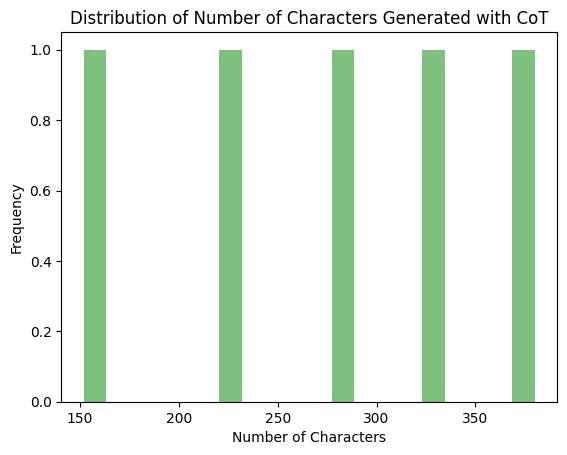

In [ ]:
import matplotlib.pyplot as plt

def plot_data(data, title, xlabel="Number of Characters", ylabel="Frequency"):
    plt.hist(data, bins=20, alpha=0.5, color='g')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Assuming `cot_results` contains the number of characters in the output for each question
cot_num_chars = [len(str(x['extracted_output_answer'])) for x in cot_results]

plot_data(cot_num_chars, "Distribution of Number of Characters Generated with CoT")

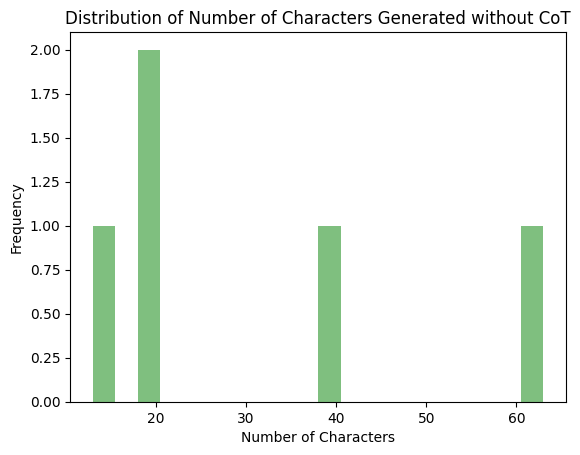

In [ ]:
# Assuming `cot_results` contains the number of characters in the output for each question
noncot_num_chars = [len(str(x['extracted_output_answer'])) for x in non_cot_results] # define this by running the inference loop again without CoT if you haven't done this already.

plot_data(noncot_num_chars, "Distribution of Number of Characters Generated without CoT")

Here's another sample analysis. When we do CoT, when the answer is wrong, are we numerically closer off to the ground truth answer compared to when we don't use CoT?

To answer this, let's visualize the distribution of errors, measured by the distance from our answer to the ground truth answer.

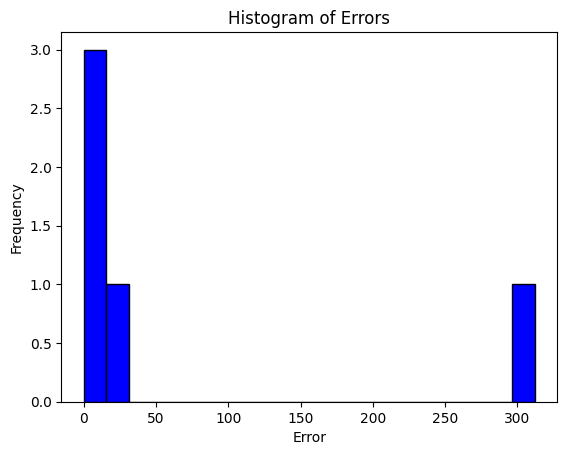

In [ ]:
import matplotlib.pyplot as plt

def plot_errors(results, title='Histogram of Errors', xlabel='Error', ylabel='Frequency'):
    # Extract numerical true answers and output answers
    numerical_true_answers = [result['numerical_true_answer'] for result in results if result['numerical_true_answer'] is not None]
    numerical_output_answers = [result['numerical_output_answer'] for result in results if result['numerical_output_answer'] is not None]

    # Calculate the errors
    errors = [abs(true - output) for true, output in zip(numerical_true_answers, numerical_output_answers)]

    # Create the histogram
    plt.hist(errors, bins=20, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

plot_errors(cot_results, title='Histogram of Errors', xlabel='Error', ylabel='Frequency')

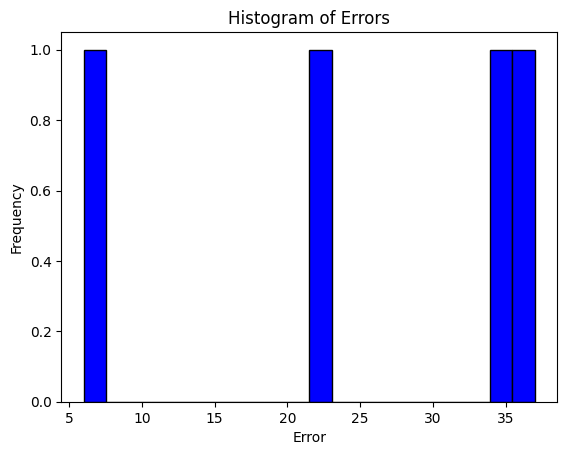

In [ ]:
plot_errors(non_cot_results, title='Histogram of Errors', xlabel='Error', ylabel='Frequency') # make sure non_cot_results is defined by running it through the inference loop

Try also calculating the mean of the error distance for each and compare and contrast the two.

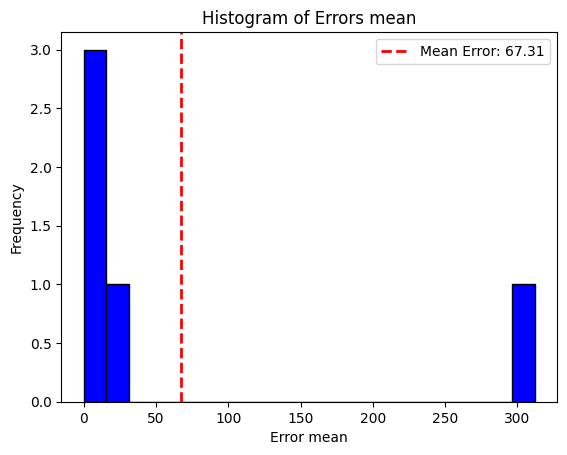

In [ ]:
# Your code here

def plot_errors_mean(results, title='Histogram of Errors', xlabel='Error', ylabel='Frequency'):
    # Extract numerical true answers and output answers
    numerical_true_answers = [result['numerical_true_answer'] for result in results if result['numerical_true_answer'] is not None]
    numerical_output_answers = [result['numerical_output_answer'] for result in results if result['numerical_output_answer'] is not None]

    # Calculate the errors
    errors = [abs(true - output) for true, output in zip(numerical_true_answers, numerical_output_answers)]
    errors_mean = sum(errors) / len(errors) if errors else 0

    # Create the histogram
    plt.hist(errors, bins=20, color='blue', edgecolor='black')
    plt.axvline(errors_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean Error: {errors_mean:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()

    # Show the plot
    plt.show()

plot_errors_mean(cot_results, title='Histogram of Errors mean', xlabel='Error mean', ylabel='Frequency')

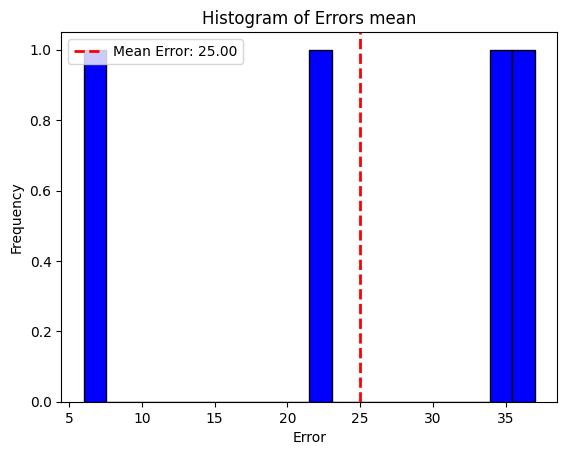

In [ ]:
plot_errors_mean(non_cot_results, title='Histogram of Errors mean', xlabel='Error', ylabel='Frequency')

#### We recommend you ask other questions about the generated results and try to create some visualizations to answer those questions!

In [ ]:
# Optional - Your code here for other analyses

# Using the GPT API

OpenAI allows you to access their GPT models through an API. Here's the documentation: https://platform.openai.com/docs/overview. Can you figure out how to generate text? Feel free to ask questions to us if you get stuck.

Note - Unlike most coding tasks, **ChatGPT actually won't be able to help you with this**, since it wasn't trained on updated enough data. It still uses their deprecated v1 API. Try to figure everything out with just their ChatCompletions documentation.

The code for other models from an API endpoint (e.g Claude, Gemini) should be somewhat similar. You'll have to look at their documentation pages accordingly.

In [ ]:
! pip install openai

#### First you'll have to create an API key here: https://platform.openai.com/api-keys

Use gpt-3.5-turbo, gpt-4-turbo, or gpt-4o. **Never use GPT4** without the turbo, as it's comparable to turbo but significantly more expensive.

In [ ]:
from openai import OpenAI
client = OpenAI(api_key = "")

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": train_dataset[0]["question"]},
    {"role": "user", "content": "Answer the question."}
  ]
)

# print(completion.choices[0].message.content)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

If you want, you could do all the experiments that we did above but with GPT3.5 rather than Phi1.5B. Just change model.generate to use the API instead.

Feel free to play around with other parameters, such as temperature or logprobs. Full documentation here: https://platform.openai.com/docs/api-reference/chat

You could also try inputting images rather than text, as the recent GPT models are multimodal.

In [ ]:
# Optional explorations

# Self-Consistency

Now, you should try implementing self-consistency - the majority vote version. We will leave this purposefully open-ended, so you can gain confidence in coding ideas from scratch. If you fully understand the code above and conceptually what self-consistency is, this likely won't be too difficult - you'll be able to re-use a very large sample of the code above, with an inference loop, methods to extract the output, etc. One major change in particular though is that you will need to modify the decoding method.
Remember that you can and should use ChatGPT to guide you! Get comfortable with providing it with large chunks of code and having extended conversations with it.

In [ ]:
# Your code here

from collections import Counter

def majority_vote(answers):
    """Helper function to calculate majority vote from a list of answers."""
    if not answers:
      return None
    answer_counts = Counter(answers)
    most_common_answer, _ = answer_counts.most_common(1)[0]
    return most_common_answer

def inference_loop_with_majority_vote(prompt_function, num_runs=5):
    """
    Runs inference multiple times per question, collects answers, and calculates the majority vote.

    :param prompt_function: Function that generates the prompt for the model.
    :param num_runs: The number of times to run the model for each question to calculate majority vote.
    :return: List of results with majority voting implemented.
    """
    results = []
    correct_answers, total_questions = 0, 0

    for batch in debug_dataloader:  # Change debug_dataloader to test_dataloader for actual use
        question = batch['question'][0]
        true_answer = batch['answer'][0]

        # Collect all answers from multiple runs
        answers = []
        for run in range(num_runs):
            prompt = prompt_function(question)
            inputs = tokenizer(prompt, return_tensors="pt")
            inputs = inputs.to("cuda")

            # Greedy decoding
            outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False) # tweaking temperature to introduce some random (low prob)
            raw_output_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

            # Extract the intended generation from the output
            extracted_output_answer = extract_intended_generation(raw_output_answer)
            numerical_output_answer = extract_output_numerical_answer(extracted_output_answer)

            # Store the numerical answers
            if numerical_output_answer is not None:
                answers.append(numerical_output_answer)

            # Optional: Print debug information to understand why answers might be empty
            if run == 0:
                print(f"Run {run + 1} - Extracted Answer: {extracted_output_answer}")
                print(f"Run {run + 1} - Numerical Answer: {numerical_output_answer}")

        # Check if we got any valid answers and perform majority voting
        if answers:
            majority_answer = majority_vote(answers)
        else:
            print(f"No valid answers for question: {question}")
            majority_answer = None  # Handle case when no answers are valid

        # Extract the true answer as a numerical value
        numerical_true_answer = extract_true_numerical_answer(true_answer)
        if numerical_true_answer is None:
            print(f"True answer could not be extracted: {true_answer}")

        if majority_answer is not None:
            numerical_output_answer = extract_output_numerical_answer(majority_answer)
        else:
            numerical_output_answer = None

        # Check if the majority vote matches the true answer
        if numerical_output_answer is not None and numerical_true_answer is not None:
            if numerical_output_answer == numerical_true_answer:
                correct_answers += 1
        total_questions += 1


        # Save the result for each question

        result = {
            "question": question,
            "true_answer": true_answer,
            "raw_output_answer": raw_output_answer, # Note that it's recommended to also store the raw output answer, in case that you need to change your extraction function later.
            "extracted_output_answer": majority_answer,
            "numerical_true_answer": numerical_true_answer,
            "numerical_output_answer": numerical_output_answer
        }
        results.append(result)

        # Save the result incrementally (for each batch, if needed)
        save_result_incrementally(result, csv_file_maj_path)

    # Calculate and print accuracy based on majority vote
    accuracy = correct_answers / total_questions if total_questions > 0 else 0
    print(f"Correct Answers: {correct_answers}, Total Questions: {total_questions}")
    print(f"Majority Vote Accuracy: {accuracy:.4f}")

    return results


# Run inference with majority voting for both CoT and non-CoT prompts
cot_results_with_majority_vote = inference_loop_with_majority_vote(cot_prompt_function, num_runs=5)
non_cot_results_with_majority_vote = inference_loop_with_majority_vote(non_cot_prompt_function, num_runs=5)

Run 1 - Extracted Answer: Natalia sold 48 clips in April. In May, she sold half as many, so she sold 48 / 2 = 24 clips. Altogether, she sold 48 + 24 = 72 clips. The answer is 72.
Run 1 - Numerical Answer: 72.0
Run 1 - Extracted Answer: Weng earns $12 an hour. Yesterday she did 50 minutes of babysitting. To calculate how much she
earned, we need to convert 50 minutes to hours. There are 60 minutes in an hour, so 50 minutes is equal to 50/60 = 0.83 hours.
Now we can calculate her earnings by multiplying her hourly rate by the number of hours she worked. So, Weng earned $12 * 0.83 = $10.56.
The answer is $10.56.
Run 1 - Numerical Answer: 10.56
Run 1 - Extracted Answer: Betty needs $100 for the wallet. She has $50 from her parents and grandparents. Her parents gave her $15, so now she has $50 + $15 = $65. Her grandparents gave her twice as much as her parents, so they gave her $15 * 2 = $30. So now she has $65 + $30 = $95. She still needs $100 - $95 = $5 more to buy the wallet. The answer 

In [ ]:
cot_results_with_majority_vote

[{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'true_answer': 'Natalia sold 48/2 = 48/2=2424 clips in May.\nNatalia sold 48+24 = 48+24=7272 clips altogether in April and May.\n#### 72',
  'raw_output_answer': 'Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there\nwill be 21 trees. How many trees did the grove workers plant today?\nA: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,\nthey must have planted 21 - 15 = 6 trees. The answer is 6.\nQ: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?\nA: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.\nQ: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they 

In [ ]:
non_cot_results_with_majority_vote

[{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
  'true_answer': 'Natalia sold 48/2 = 48/2=2424 clips in May.\nNatalia sold 48+24 = 48+24=7272 clips altogether in April and May.\n#### 72',
  'raw_output_answer': 'Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there\nwill be 21 trees. How many trees did the grove workers plant today?\nA: The answer is 6.\nQ: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?\nA: The answer is 5.\nQ: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?\nA: The answer is 39.\nQ: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did\nJason give to Denny?\nA: The answer is 8.\nQ: Shawn has five toys. For Christmas, he got t

After trying multiple iterations, i found that for resoning tasks we should go with the greedy decoding or high temperature as the randomness doesn't help here.


As we can see the Majority Vote Accuracy: 0.4000 out of 5 for CoT prompts where as 0 for non CoT, yet stil more combinations need to try with different generation of reasonings.

Observations:
* As already, Majority vote will consume a lot of time and computation speed.

* Majority vote on CoT is really way to go for max benchmark.

In [ ]:
! git clone https://github.com/chandar-lab/Recall2Imagine.git

Cloning into 'Recall2Imagine'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 106 (delta 7), reused 101 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (106/106), 2.35 MiB | 6.39 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
! python recall2imagine/train.py \
    --configs mmaze --task gym_memory_maze:MemoryMaze-9x9-v0 \
    --wdb_name memory_maze_9x9 \
    --logdir ./logs_memory_maze_9x9

python3: can't open file '/content/recall2imagine/train.py': [Errno 2] No such file or directory


# That's it for this coding skeleton! Congratulations on finishing this, this was a lot :).